In [1]:
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from itertools import combinations

%matplotlib inline

In [2]:
#load modality to feature dict
with open('../../data/simulations/ihmp/mod_to_feature_map.pkl', 'rb') as f:
   mod_features = pickle.load(f)

In [3]:
#load top and bottom features from each fold
#joint-rpca
with open("../../data/simulations/ihmp/feature-overlap/joint-last-feat-list-50.pkl", "rb") as f:
    joint_fold_feats = pickle.load(f)
#mofa
with open("../../data/simulations/ihmp/feature-overlap/mofa-last-feat-list-50.pkl", "rb") as f:
    mofa_fold_feats = pickle.load(f)

n_feats = 50 #top 25 + bottom 25, 5 top/bottom from each modality

In [4]:
sims = ['meta_g_taxonomic_profiles', 'meta_g_taxonomic_profiles_11', 
        'meta_g_taxonomic_profiles_9', 'meta_g_taxonomic_profiles_7',
        'meta_g_taxonomic_profiles_5', 'meta_g_taxonomic_profiles_3']

omic_title = {'virome_virmap_analysis': 'Virome', 'meta_t_ecs': 'MetaT', 'All': 'All',
              'meta_g_taxonomic_profiles': 'MetaG', 'HMP2_metabolomics': 'Metabolomics',
              'HMP2_proteomics_ecs': 'Proteomics'}

density_title = {'meta_g_taxonomic_profiles': "Density: 12% (original)", 
                 'meta_g_taxonomic_profiles_11': "Density: 11%", 
                 'meta_g_taxonomic_profiles_9': "Density: 9%", 
                 'meta_g_taxonomic_profiles_7': "Density: 7%",
                 'meta_g_taxonomic_profiles_5': "Density: 5%", 
                 'meta_g_taxonomic_profiles_3': "Density: 3%"}

for sim in sims:
    omic_title[sim] = 'MetaG'

In [5]:
def filter_by_sparsity(data, sparsity_level):
    
    return {
        fold: modalities
        for (fold, sparsity), modalities in data.items()
        if sparsity == sparsity_level
    }

def overlap_matrix(data, modality, normalize=False):
    
    folds = sorted(data.keys(), key=lambda x: int(x))
    folds_formatted = [f"Fold{int(f)}" for f in folds]

    matrix = pd.DataFrame(0, index=folds_formatted, 
                          columns=folds_formatted)
    
    for f1, f2 in combinations(folds, 2):
        set1 = data[f1][modality]
        set2 = data[f2][modality]
        overlap = len([x for x in set1 if x in set2])

        f1_, f2_ = f"Fold{int(f1)}", f"Fold{int(f2)}"
        matrix.loc[f1_, f2_] = overlap
        matrix.loc[f2_, f1_] = overlap
    
    for f in folds:
        f_ = f"Fold{int(f)}"
        matrix.loc[f_, f_] = len(data[f][modality])
    
    if normalize:
        n_features = len(set(data[folds[0]][modality]))
        #print("Detected {} features total".format(n_features))
        matrix = 100 * (matrix / n_features)
        matrix = matrix.astype(int)
        matrix = matrix.astype(str) + "%"
    
    return matrix

def plot_overlap_heatmap(matrix_str, title=None, cmap="Reds"):

    # convert strings back to numeric for plotting
    matrix_numeric = matrix_str.replace("%", "", regex=True).astype(int)

    #mask to only plot lower diagonal
    mask = np.triu(np.ones_like(matrix_numeric, dtype=bool), k=1)
    
    plt.figure(figsize=(8,6))
    sns.heatmap(matrix_numeric, annot=matrix_str,
                fmt="",  # avoid formatting numeric annotation
                cmap=cmap, cbar_kws={"label": "Overlap (%)"},
                vmin=0, vmax=100,
                mask=mask, square=True)
    
    if title:
        plt.title(title, y=1.01)
    plt.yticks(rotation=0)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### Top features across folds for each method 

In [6]:
joint_mods_per_mod = {}
for (f_, sparsity_) in joint_fold_feats.keys():
    
    joint_top_plus_bottom = np.concatenate(joint_fold_feats[(f_, sparsity_)])
    overlap_mods = {}
    
    for mod_, feats_ in mod_features.items():
        overlap_set_mod_ = [x for x in joint_top_plus_bottom if x in feats_]
        overlap_mods[mod_] = overlap_set_mod_
        
    joint_mods_per_mod[(f_, sparsity_)] = overlap_mods

mofa_mods_per_mod = {}
for (f_, sparsity_) in mofa_fold_feats.keys():
    
    mofa_top_plus_bottom = np.concatenate(mofa_fold_feats[(f_, sparsity_)])
    overlap_mods = {}
    
    for mod_, feats_ in mod_features.items():
        overlap_set_mod_ = [x for x in mofa_top_plus_bottom if x in feats_]
        overlap_mods[mod_] = overlap_set_mod_
        
    mofa_mods_per_mod[(f_, sparsity_)] = overlap_mods

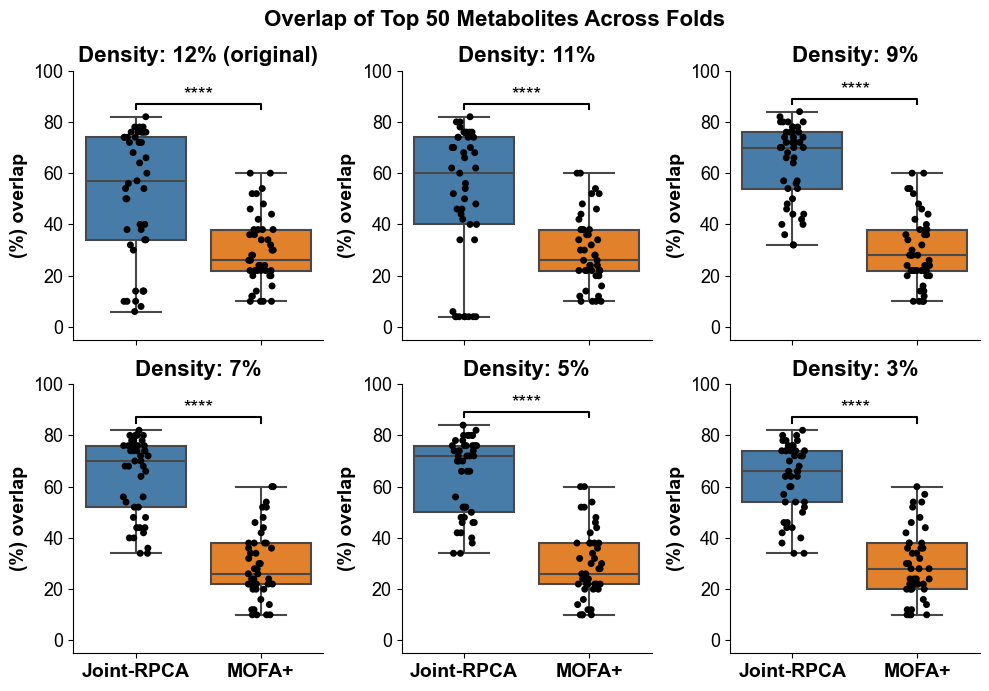

In [14]:
fig, axn = plt.subplots(2, 3, figsize=(10, 7), sharex=True)
axn = axn.flatten()
modality = 'HMP2_metabolomics'

for sim_, ax in zip(sims, axn):

    #print(sim_)
    joint_sim_ = filter_by_sparsity(joint_mods_per_mod, sim_)
    joint_sim_matrix_ = overlap_matrix(joint_sim_, modality, normalize=True)
    joint_sim_matrix_ = joint_sim_matrix_.replace("%", "", regex=True).astype(int)

    mofa_sim_ = filter_by_sparsity(mofa_mods_per_mod, sim_)
    mofa_sim_matrix_ = overlap_matrix(mofa_sim_, modality, normalize=True)
    mofa_sim_matrix_ = mofa_sim_matrix_.replace("%", "", regex=True).astype(int)

    #get lower values (excluding diagonal)
    mask_upper = np.tril(np.ones(joint_sim_matrix_.shape), k=-1).astype(bool)  
    joint_upper_vals = joint_sim_matrix_.where(mask_upper).stack().values
    mofa_upper_vals = mofa_sim_matrix_.where(mask_upper).stack().values

    merged_upper_vals = pd.DataFrame({"Overlap": np.concatenate([joint_upper_vals, mofa_upper_vals]),
                                      "Method": ["Joint-RPCA"] * len(joint_upper_vals) + ["MOFA+"] * len(mofa_upper_vals)})
    
    method_palette = {"Joint-RPCA": "#377eb8", "MOFA+":"#ff7f0e"}

    sns.boxplot(data=merged_upper_vals, x="Method", y="Overlap",
                order=["Joint-RPCA", "MOFA+"],
                palette=method_palette, ax=ax)
    sns.stripplot(data=merged_upper_vals, x="Method", y="Overlap", 
                order=["Joint-RPCA", "MOFA+"], 
                color='k', dodge=False, ax=ax)

    a_ = merged_upper_vals[merged_upper_vals.Method=='Joint-RPCA']['Overlap']
    b_ = merged_upper_vals[merged_upper_vals.Method=='MOFA+']['Overlap']
    U_, p_ = mannwhitneyu(a_, b_)
    x1, x2 = 0, 1  
    y, h, col = np.max([np.max(a_), np.max(b_)]) + 3, 2, 'k'
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)

    if p_ < 0.0001:
        p_show = '****'
    else:
        p_show = "P=%.3f" % (p_)
    ax.text((x1+x2)*.5, y+h, p_show, ha='center',
            va='bottom', color=col, fontsize=14, fontname='Arial')
    ax.set_ylim(-5, 100)

    sns.despine()
    ax.set_title(density_title[sim_],fontweight='bold', 
                 fontsize=16, fontname='Arial')
    ax.set_ylabel("(%) overlap", fontsize=14, 
                  fontweight='bold', fontname='Arial')
    ax.set_xlabel("")
    for tick in ax.get_yticklabels():
        tick.set_fontproperties('arial')
        tick.set_color("black")
        tick.set_fontsize(13)
    for tick in ax.get_xticklabels():
        tick.set_fontproperties('arial')
        tick.set_color("black")
        tick.set_fontweight('bold')
        tick.set_fontsize(14)

plt.suptitle("Overlap of Top 50 Metabolites Across Folds", 
             fontsize=16, fontweight='bold', fontname='Arial')
plt.tight_layout()
plt.savefig("../../results/supp-fig2C.pdf",
            dpi=600, bbox_inches='tight', 
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

Examine metabolite annotations

In [ ]:
metab_annot = pd.read_csv('../../data/simulations/ihmp/metabolite_annotations.txt', sep='\t', index_col=0)
display(metab_annot.head())

metab_annot_dict = dict(zip(metab_annot.index, metab_annot['Metabolite']))

In [ ]:
for f_ in range(1,11):
    f_ = str(f_)

    joint_metabs = joint_mods_per_mod[(f_,'meta_g_taxonomic_profiles')]['HMP2_metabolomics'].copy()
    #joint_metabs = [metab_annot_dict[x] for x in joint_metabs]
    print("Fold%s" % f_)
    display(metab_annot.loc[joint_metabs, ['Metabolite']].reset_index().dropna())
    #print(joint_metabs)

In [ ]:
for f_ in range(1,11):
    f_ = str(f_)
    mofa_metabs = mofa_mods_per_mod[(f_,'meta_g_taxonomic_profiles')]['HMP2_metabolomics'].copy()
    #mofa_metabs = [metab_annot_dict[x] for x in mofa_metabs]
    print("Fold%s" % f_)
    display(metab_annot.loc[mofa_metabs, ['Metabolite']].reset_index().dropna())
    #print(mofa_metabs)